In [10]:
# Import Python Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import csv
import pathlib
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from PIL import Image

In [11]:
#Split the Dataset into validation and training datasets to feed into the ML model
#path to the directory containing the images
data_dir = pathlib.Path(os.fsdecode('Images/')).with_suffix('')

#set the batch size to 32 and image to 180x180
BATCH_SIZE = 32
IMG_SIZE = (180, 180)

#create the training and validation dataset with an 80/20 split using the images in the images folder
#80% training and 20% validation
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
##Create the ML model to be used for image classification
model = Sequential([
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(6, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(5, activation='relu'),
    Dense(5)])

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#fit it using 20 epochs for increased accuracy
history = model.fit(training_ds, epochs=2, validation_data=validation_ds)

Epoch 1/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.2647 - loss: 1.5656 - val_accuracy: 0.3501 - val_loss: 1.4949
Epoch 2/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3799 - loss: 1.4539 - val_accuracy: 0.4346 - val_loss: 1.3841


In [4]:
#SAVE the model
model.save('flower_classify_model.keras')

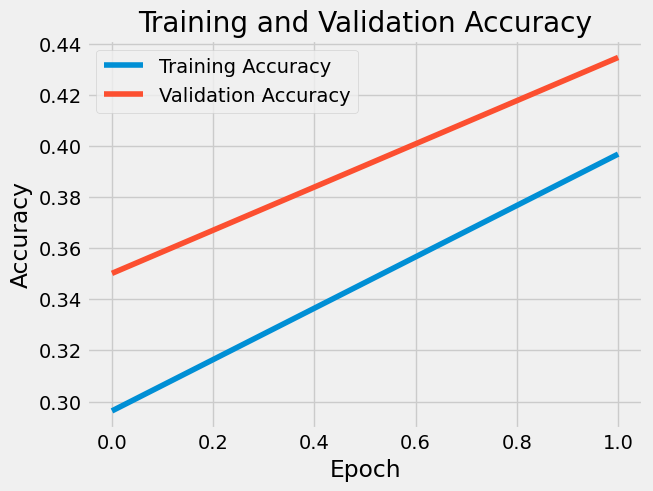

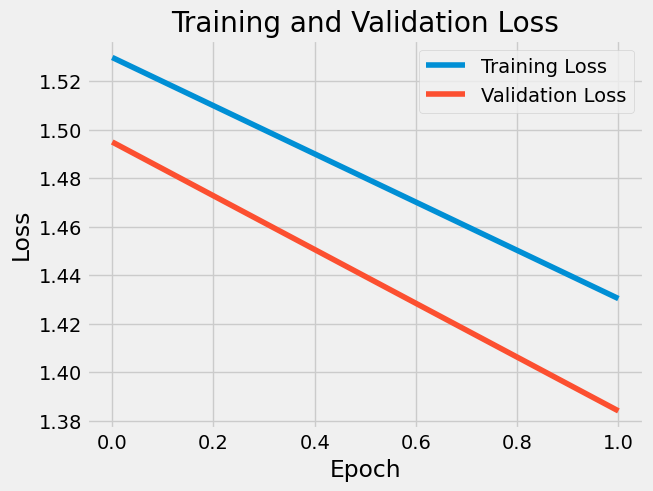

In [13]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

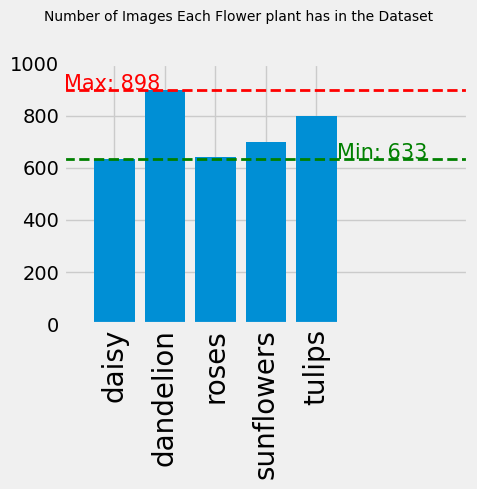

In [14]:
#Create Visualization #1 - Bar plot of Number of Images per plant
plant_names = []
resultsImages = []

#loop through the directories and get the names of the plants, and quantity of files in each plants folder
dirs = os.listdir('Images/')
for dir in dirs:
    files = list(os.listdir('Images/'+dir))
    plant_names.append(str(dir))
    resultsImages.append(int(len(files)))
    
#convert plant names and count to numpy arrays for easy plotting
vis_plantNames = np.array(plant_names)
vis_plantCount = np.array(resultsImages)



#create bar plot
fig, ax = plt.subplots(figsize= (5,5))
species_bar = ax.bar(vis_plantNames,vis_plantCount)
fig.suptitle('Number of Images Each Flower plant has in the Dataset', fontsize=10)
plt.xticks(rotation='vertical', fontsize=20)
plt.style.use('fivethirtyeight')
ax.set_xlim(-1,7)
ax.set_ylim(0,1000)
plt.tight_layout()

#annotation for max and min
max=vis_plantCount.max()
min=vis_plantCount.min()
ax.axhline(y=max, color='r', linestyle='--', label=max, linewidth=2)
ax.annotate(text="Max: " + str(max), xy=(-1,max),xytext=(-1,max), color='r', fontsize=15)
ax.axhline(y=min, color='g', linestyle='--', label=min, linewidth=2)
ax.annotate(text="Min: " + str(min), xy=(0,max),xytext=(4.4,min), color='g', fontsize=15)


#save and display the visualization
#plt.savefig('Visualization1.jpeg')
plt.show()

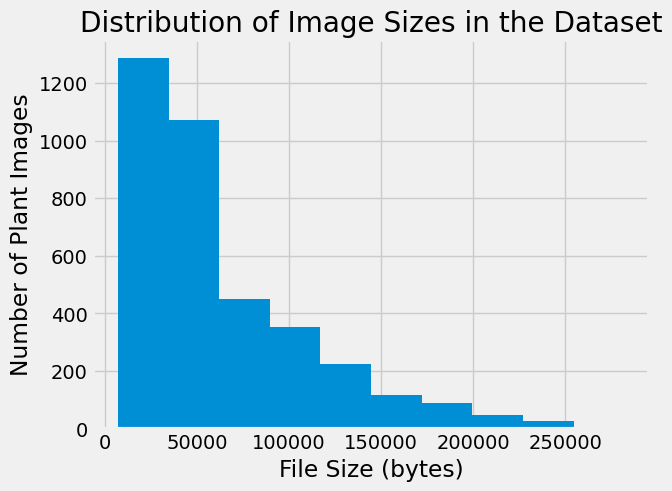

In [15]:
#Create Visualization 2 - Distribution of Image sizes in the dataset
root_path = 'Images/'

# Initialize empty lists to store the information
sizes = []
resolutions = []
color_distributions = []

# Iterate over each image file in each subdirectory
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg')):
            # Load the image file using OpenCV
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path)

            # Extract the size of the image
            size = os.path.getsize(img_path)
            sizes.append(size)

# Convert the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)


# Plot a histogram of the image sizes
plt.hist(sizes)
plt.title("Distribution of Image Sizes in the Dataset")
plt.xlabel("File Size (bytes)")
plt.ylabel("Number of Plant Images")

#save and display the visualization
plt.savefig('Visualization2.jpeg')
plt.show()

In [ ]:
#Create Visualization #3, create CSV file to store plant Rgbs to calcualte average rgb and display in a 3D graph
# Function to calculate average RGB for a single image
def calculate_average_rgb(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        np_img = np.array(img)
        avg_color = np.mean(np_img, axis=(0, 1))  # Average along width and height
    return avg_color

# Function to process each subdirectory and calculate the average RGB
def process_images_in_directory(root_dir):
    results = []  # To store subdirectory name and average RGB
    
    # Loop through subdirectories
    for subdir, _, files in os.walk(root_dir):
        rgb_values = []
        
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                avg_rgb = calculate_average_rgb(img_path)
                rgb_values.append(avg_rgb)
        
        # If images were found, calculate average RGB for the subdirectory
        if rgb_values:
            avg_rgb_subdir = np.mean(rgb_values, axis=0)  # Average across all images
            subdir_name = os.path.basename(subdir)
            results.append([subdir_name, avg_rgb_subdir[0], avg_rgb_subdir[1], avg_rgb_subdir[2]])

    return results

# Function to calculate mean of three columns and add it to a new column
def add_mean_column(csv_filename, col1, col2, col3, new_col_name='Mean'):
    rows = []
    
    # Open and read the CSV file
    with open(csv_filename, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        fieldnames = reader.fieldnames + [new_col_name]  # Add the new column name
        for row in reader:
            # Calculate the mean of the three columns
            mean_value = (float(row[col1]) + float(row[col2]) + float(row[col3])) / 3
            row[new_col_name] = round(mean_value, 2)  # Add mean value to new column (rounded to 2 decimals)
            rows.append(row)

    # Write the updated data back to the same CSV file
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()  # Write the header with the new column
        writer.writerows(rows)  # Write all the rows
        
# Save results to a CSV file
def save_results_to_csv(results, csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Subdirectory", "Average R", "Average G", "Average B"])
        writer.writerows(results)

# Main function to execute the script
if __name__ == "__main__":
    root_directory = 'Images/'  # Replace with your directory path
    output_csv = 'average_rgb_per_subdirectory.csv'
    
    # Process images and calculate average RGB
    results = process_images_in_directory(root_directory)
    
    # Save the results to CSV
    save_results_to_csv(results, output_csv)

    csv_file = 'average_rgb_per_subdirectory.csv'  # Replace with your actual CSV file path
    column1 = "Average R"  # Replace with your actual column names
    column2 = "Average G"
    column3 = "Average B"
    
    # Call the function to process the CSV
    add_mean_column(csv_file, column1, column2, column3)

In [ ]:
#Display Visualization 3 by reading created CSV file - Average RGB of each plant

#open the CSV that was made
data = pd.read_csv('average_rgb_per_subdirectory.csv')

x=data['Average R']
y=data['Average G']
z=data['Average B']

colors = []
colors = [data['Mean'][0],data['Mean'][1],data['Mean'][2],data['Mean'][3],data['Mean'][4]]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10,10))
fig.suptitle('Average RGB of each plant', fontsize=50)
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=colors, marker='o')

ax.set_xlabel('Red Value')
ax.set_ylabel('Green Value')
ax.set_zlabel('Blue Value')

#display the text to show what dot represents each plant
ax.text(x=x[0], y=y[0], z=z[0], s='Daisy' )
ax.text(x=x[1], y=y[1], z=z[1], s='Dandelion' )
ax.text(x=x[2], y=y[2], z=z[2], s='Roses' )
ax.text(x=x[3], y=y[3], z=z[3], s='Sunflowers' )
ax.text(x=x[4], y=y[4], z=z[4], s='Tulips' )
    
#save and display the visualization
plt.savefig('Visualization3.jpeg')
plt.show()